In [6]:
import numpy as np
import scipy as scp
import scipy.stats as ss
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from scipy.special import iv
from scipy.optimize import minimize
from Processes import Merton_process

<a id='sec1'></a>
# Brownian motion

Let us simulate some Brownian paths.    
Remember that the (standard) Brownian motion $\{X_t\}_{t\geq 0}$ is a continuous time stochastic process, that satisfies the following properties:
- $X_{0} = 0$.
- The increments are stationary and independent. (see **A3** for the definition)
- It is a martingale.
- It has continuous paths, but nowhere differentiable.
- $X_t - X_s \sim \mathcal{N}(0,t-s)$ for $t\geq s \geq 0$.

For more info see here [wiki](https://en.wikipedia.org/wiki/Brownian_motion).

In our simulation, each increments is such that:

$$ X_{t_i+\Delta t} - X_{t_i} = \Delta X_i \sim \mathcal{N}(\mu \Delta t,\, \sigma^2 \Delta t). $$

The process at time T is given by $X_T = \sum_i \Delta X_i$ and follows the distribution:

$$ X_T \sim \mathcal{N}(\mu T,\, \sigma^2 T). $$

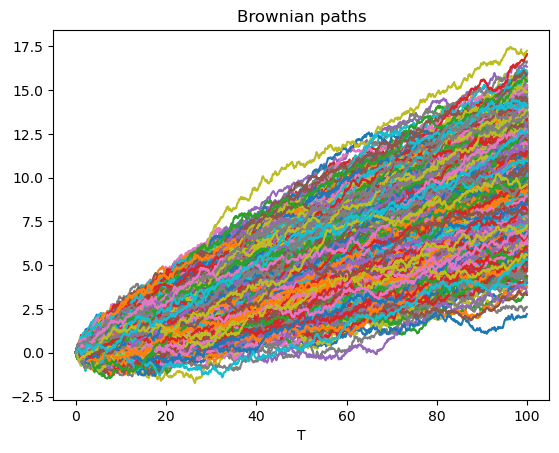

In [3]:
# scipy.stats uses numpy.random to generate its random numbers
np.random.seed(seed=42)

paths = 4000  # number of paths
steps = 1000  # number of time steps

mu = 0.1  # drift
sig = 0.2  # diffusion coefficient or volatility
T = 100
T_vec, dt = np.linspace(0, T, steps, retstep=True)

X0 = np.zeros((paths, 1))  # each path starts at zero
increments = ss.norm.rvs(loc=mu * dt, scale=np.sqrt(dt) * sig, size=(paths, steps - 1))

X = np.concatenate((X0, increments), axis=1).cumsum(1)

plt.plot(T_vec, X.T)
plt.title("Brownian paths")
plt.xlabel("T")
plt.show()

<a id='sec1'></a>
# Merton Jump-Diffusion process

The Merton process is described by the following equation:

\begin{equation}
X_t = \mu t + \sigma W_t + \sum_{i=1}^{N_t} Y_i, 
\end{equation}

where $N_t \sim Po(\lambda t)$ is a Poisson random variable counting the jumps of $X_t$ in $[0,t]$, and 

$$Y_i \sim \mathcal{N}(\alpha, \xi^2)$$ 

are the sizes of the jumps.     
In the following I indicate $\mu \to$ `mu`, $\sigma \to $ `sig`, $\lambda \to $ `lam`, $\alpha \to $ `muJ` and $\xi \to $ `sigJ`.

In [4]:
mu = 0.05  # drift
sig = 0.2  # diffusion coefficient
lam = 1.2  # jump activity
muJ = 0.15  # jump mean size
sigJ = 0.5  # jump std deviation
T = 2  # terminal time
N = 1000000  # number of random variables
r = 0.05  # risk-free rate
S0 = 100  # initial stock price
K = 103  # strike price

In [5]:
np.random.seed(seed=42)
W = ss.norm.rvs(0, 1, N)  # The normal RV vector
P = ss.poisson.rvs(lam * T, size=N)  # Poisson random vector
Jumps = np.asarray([ss.norm.rvs(muJ, sigJ, i).sum() for i in P])  # Jumps vector
X_T = mu * T + np.sqrt(T) * sig * W + Jumps  # Merton process

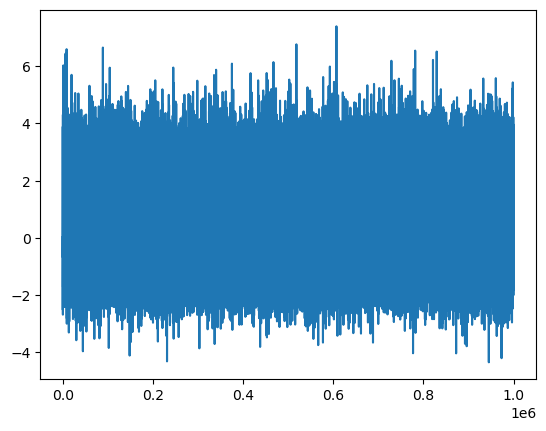

In [6]:
#single path
plt.plot(X_T)

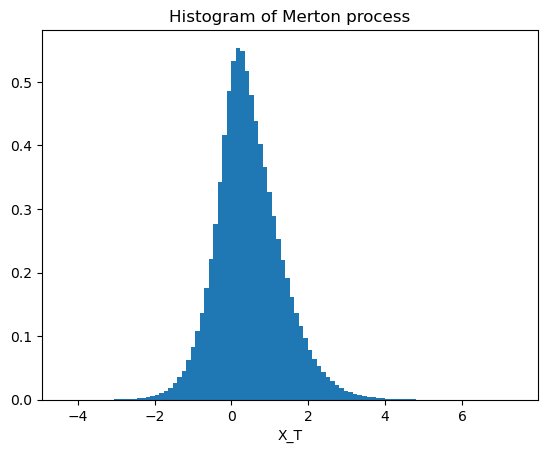

In [7]:
#plot the histogram
plt.hist(X_T, bins=100, density=True)
plt.title("Histogram of Merton process")
plt.xlabel("X_T")
plt.show()

In [8]:
np.random.seed(seed=44)  # seed for random number generation

S_T = S0 * np.exp(W)

call = np.mean(np.exp(-r * T) * np.maximum(S_T - K, 0))
put = np.mean(np.exp(-r * T) * np.maximum(K - S_T, 0))
call_err = ss.sem(np.exp(-r * T) * np.maximum(S_T - K, 0))  # standard error
put_err = ss.sem(np.exp(-r * T) * np.maximum(K - S_T, 0))  # standard error

print("Call price: {}, with error: {}".format(call, call_err))
print("Put price: {}, with error: {}".format(put, put_err))

Call price: 78.68661001944128, with error: 0.18222047951877424
Put price: 22.993364702073368, with error: 0.027968394157304653


In [9]:
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    """
    S: Initial stock price
    K: Option strike price
    T: Time to maturity
    r: Risk-free rate
    sigma: Volatility
    option_type: Type of option ('call' or 'put')
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        option_price = (S * ss.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * ss.norm.cdf(d2, 0.0, 1.0))
    elif option_type == 'put':
        option_price = (K * np.exp(-r * T) * ss.norm.cdf(-d2, 0.0, 1.0) - S * ss.norm.cdf(-d1, 0.0, 1.0))
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'")
    
    return option_price

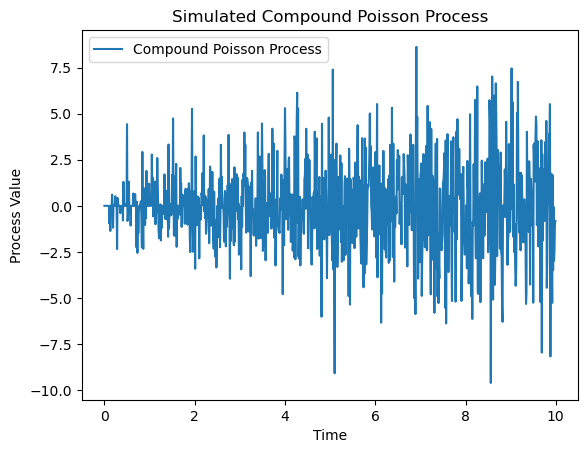

In [10]:
# Parameters
lambda_val = 1.0  # Poisson arrival rate of jumps
jump_mean = 0.0  # Mean of jump sizes
jump_std = 1.0  # Standard deviation of jump sizes
T = 10  # Total time
dt = 0.01  # Time increment

# Simulate Compound Poisson Process
times = np.arange(0, T, dt)
X_t = np.zeros_like(times)
for i, t in enumerate(times[1:], start=1):
    # Number of jumps in [0, t], Poisson distributed
    num_jumps = np.random.poisson(lambda_val * t)
    
    # Generate jump sizes, normally distributed for this example
    jumps = np.random.normal(jump_mean, jump_std, num_jumps)
    
    X_t[i] = np.sum(jumps)

# Plot the simulated process
plt.plot(times, X_t, label='Compound Poisson Process')
plt.xlabel('Time')
plt.ylabel('Process Value')
plt.title('Simulated Compound Poisson Process')
plt.legend()
plt.show()


In [11]:
def monte_carlo_levy_control_variate(S, K, T, r, lambda_val, jump_mean, jump_std, sigma, num_paths):
    dt = 0.01  # Time increment
    times = np.arange(0, T, dt)
    option_payoffs = np.zeros(num_paths)
    bs_prices = np.zeros(num_paths)
    
    for i in range(num_paths):
        X_t = 0  # Initialize the Lévy process value
        for t in times[1:]:
            # Simulate the Lévy process (e.g., compound Poisson process)
            num_jumps = np.random.poisson(lambda_val * dt)
            jumps = np.random.normal(jump_mean, jump_std, num_jumps)
            X_t += np.sum(jumps)
            
            # Simulate the stock price under the Lévy model
            S_t = S * np.exp(r * t + X_t)
        
        # Calculate option payoff at maturity
        option_payoffs[i] = np.maximum(S_t - K, 0)
        
        # Calculate Black-Scholes price as a control variate
        bs_prices[i] = black_scholes_price(S, K, T, r, sigma, option_type='call')
        
    # Compute optimal alpha for control variate adjustment
    cov_matrix = np.cov(option_payoffs, bs_prices)
    alpha_opt = -cov_matrix[0, 1] / cov_matrix[1, 1]
    
    # Adjust option payoffs using Black-Scholes control variate
    adjusted_payoffs = option_payoffs + alpha_opt * (bs_prices - np.mean(bs_prices))
    
    # Estimate option price
    option_price_estimate = np.exp(-r * T) * np.mean(adjusted_payoffs)
    
    return option_price_estimate


In [12]:
monte_carlo_levy_control_variate(S=100, K=100, T=10, r=0.05, lambda_val=1.0, jump_mean=0.0, jump_std=1.0, sigma=0.2, num_paths=10000)

13669.570387222975

In [1]:
def LSM(T, r, sig, S0, K, payoff="put", N=10000, paths=10000, order=2):
    """
    Longstaff-Schwartz Method for pricing American options

    T = maturity time
    r = risk free rate
    sig = stock volatility
    S0 = initial stock price
    K = strike price
    payoff = type of the option ("put")
    N = number of time steps
    paths = number of generated paths
    order = order of the polynomial for the regression
    """

    if payoff != "put":
        raise ValueError("invalid type. Set 'call' or 'put'")

    dt = T / (N - 1)  # time interval
    df = np.exp(-r * dt)  # discount factor per time time interval

    X0 = np.zeros((paths, 1))
    increments = ss.norm.rvs(
        loc=(r - sig**2 / 2) * dt,
        scale=np.sqrt(dt) * sig,
        size=(paths, N - 1),
    )
    X = np.concatenate((X0, increments), axis=1).cumsum(1)
    S = S0 * np.exp(X)

    H = np.maximum(K - S, 0)  # intrinsic values for put option
    V = np.zeros_like(H)  # value matrix
    V[:, -1] = H[:, -1]

    # Valuation by LS Method
    for t in range(N - 2, 0, -1):
        good_paths = H[:, t] > 0
        rg = np.polyfit(S[good_paths, t], V[good_paths, t + 1] * df, 2)  # polynomial regression
        C = np.polyval(rg, S[good_paths, t])  # evaluation of regression

        exercise = np.zeros(len(good_paths), dtype=bool)
        exercise[good_paths] = H[good_paths, t] > C

        V[exercise, t] = H[exercise, t]
        V[exercise, t + 1 :] = 0
        discount_path = V[:, t] == 0
        V[discount_path, t] = V[discount_path, t + 1] * df

    V0 = np.mean(V[:, 1]) * df  #
    return V0

In [4]:
option_price = LSM(T=1, r=0.05, sig=0.2, S0=100, K=100, payoff="put")
print(option_price)

6.158409216396639


In [5]:
import numpy as np
import scipy.stats as ss

def LSM(T, r, S, K, payoff="put", N=10000, order=2):
    """
    Longstaff-Schwartz Method for pricing American options

    T = maturity time
    r = risk free rate
    S = stock price matrix, with each column representing a time step and each row representing a different path
    K = strike price
    payoff = type of the option ("put")
    N = number of time steps
    order = order of the polynomial for the regression
    """

    if payoff != "put":
        raise ValueError("invalid type. Set 'call' or 'put'")

    dt = T / (N - 1)  # time interval
    df = np.exp(-r * dt)  # discount factor per time interval

    H = np.maximum(K - S, 0)  # intrinsic values for put option
    V = np.zeros_like(H)  # value matrix
    V[:, -1] = H[:, -1]

    # Valuation by LS Method
    for t in range(N - 2, 0, -1):
        good_paths = H[:, t] > 0
        rg = np.polyfit(S[good_paths, t], V[good_paths, t + 1] * df, order)  # polynomial regression
        C = np.polyval(rg, S[good_paths, t])  # evaluation of regression

        exercise = np.zeros(len(good_paths), dtype=bool)
        exercise[good_paths] = H[good_paths, t] > C

        V[exercise, t] = H[exercise, t]
        V[exercise, t + 1 :] = 0
        discount_path = V[:, t] == 0
        V[discount_path, t] = V[discount_path, t + 1] * df

    V0 = np.mean(V[:, 1]) * df  #
    return V0


In [8]:
def exp_RV_paths(self, S0, T, N, paths):
    dt = T / (N-1)
    S = np.zeros((paths, N))
    S[:, 0] = S0

    for t in range(1, N):
        m = self.lam * (np.exp(self.muJ + (self.sigJ**2) / 2) - 1)  # coefficient m
        W = ss.norm.rvs(0, 1, paths)  # The normal RV vector
        P = ss.poisson.rvs(self.lam * dt, size=paths)  # Poisson random vector (number of jumps)
        Jumps = np.asarray([ss.norm.rvs(self.muJ, self.sigJ, ind).sum() for ind in P])  # Jumps vector

        # Incremental Merton exponential dynamics for paths
        S[:, t] = S[:, t-1] * np.exp(
            (self.r - 0.5 * self.sig**2 - m) * dt + np.sqrt(dt) * self.sig * W + Jumps
        )

    return S

S = exp_RV_paths(T=1, N=1000, paths=1000, S0=100)

LSM(T=1, r=0.02, S=S, K=100, payoff="put")

TypeError: exp_RV_paths() missing 1 required positional argument: 'self'